In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import sys, os
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from MetaIPM import network
from MetaIPM import populated_network
from MetaIPM import stochastic_wrapper as sw
from MetaIPM import summarize_outputs as so
from MetaIPM import recruitment
data_file_path = "./ModelData/"
import matplotlib as mpl
import cycler

In [3]:
network_file = "network.csv"
transition_probs = "psi.csv"
transition_key = "psi_key.csv"
node_file = "node.csv"
group_file = "group_details.csv"
lw_file = "LW_Pool.csv"
vonB_file = "vonB.csv"
vonB_sigma_file = "vonB_sigma.csv"
maturity_file = "maturity.csv"

In [4]:
network_data = pd.read_csv(data_file_path + network_file)
transition_data = pd.read_csv(data_file_path  + transition_probs)
transition_key_data = pd.read_csv(data_file_path  + transition_key)
node_data = pd.read_csv(data_file_path + node_file)
group_data = pd.read_csv(data_file_path + group_file)
lw_data = pd.read_csv(data_file_path + lw_file)
vonB_data = pd.read_csv(data_file_path + vonB_file)
vonB_sigma_data = pd.read_csv(data_file_path + vonB_sigma_file)
maturity_data = pd.read_csv(data_file_path + maturity_file)

In [5]:
def make_model():
    deterministic_model = populated_network.populate_network_from_csv(
        network_data = network_data,
        transition_data = transition_data,
        transition_key_data = transition_key_data,
        node_data = node_data,
        group_data = group_data,
        lw_data = lw_data,
        vonB_data = vonB_data,
        vonB_sigma_data = vonB_sigma_data,
        maturity_data = maturity_data,
        stochastic_spawn = False,
        stochastic_pars = False
        ).show_network()
    return deterministic_model

In [6]:
def extract_population(deterministic_model):
    out_all = so.extract_all_populations(deterministic_model)
    out_all = out_all[out_all["Year"] < out_all["Year"].max()]

    out_by_node = out_all.groupby(['Year','Month','Node'])[['Population']].sum().reset_index()
    out_by_node["Months"] = out_by_node["Month"] + out_by_node["Year"]
    out_by_node = out_by_node[out_by_node["Month"] == 0]
    out_by_node['Years'] = out_by_node['Months']
    
    return out_by_node[['Years', 'Population', 'Node']]

In [7]:
def graph_results(scenarios, labels, folder, title, control_scen=None, control_label='', label_title=''):
    n = len(scenarios)
    color = plt.cm.viridis(np.linspace(0.1,0.9,n)) # This returns RGBA; convert:
    mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
    
    # Plot Nodes
    fig, axs = plt.subplots(1, 2, sharey=True,
                           subplot_kw={'box_aspect':1},
                           gridspec_kw={'wspace':0.05})
    plt.style.use('seaborn-whitegrid')
    
    ## La Grange
    plt.sca(axs[0])
    if control_scen is not None:
        sc = control_scen
        a = sc[sc['Node'] == 'a']
        plt.plot(a['Years'], a['Population']/1_000_000, label=control_label, linestyle='dotted', color='black')
    for i in range(len(scenarios)):
        sc = scenarios[i]
        a = sc[sc['Node'] == 'a']
        plt.plot(a['Years'], a['Population']/1_000_000, label=labels[i])
    plt.ylim(0, 1)
    plt.title('La Grange', fontsize=15)
    plt.xlabel('Years', fontsize=15)
    plt.ylabel('Population (millions)', fontsize=15)
    #plt.yticks([0, 100_000, 200_000, 300_000, 400_000],
    #           ['0', '100,000', '200,000', '300,000', '400,000'])
    
    
    ## Peoria
    plt.sca(axs[1])
    if control_scen is not None:
        sc = control_scen
        a = sc[sc['Node'] == 'b']
        plt.plot(a['Years'], a['Population']/1_000_000, linestyle='dotted', color='black')
    for i in range(len(scenarios)):
        sc = scenarios[i]
        b = sc[sc['Node'] == 'b']
        plt.plot(b['Years'], b['Population']/1_000_000)
    plt.title('Peoria', fontsize=15)
    plt.xlabel('Years', fontsize=15)
    plt.ylabel('Population', fontsize=15)
    axs[1].label_outer()

    ## General
    #plt.suptitle(title, fontsize=20)
    plt.subplots_adjust(top=1, right=0.76)
    #plt.ylim(0, 400000000000)
    fig.legend(frameon=True, loc='center right', title=label_title)
    plt.savefig(f'{folder}/{title}.svg', bbox_inches='tight')
    plt.show()

In [8]:
def test_model(g, title):
    mask = vonB_data['parameter'] == 'g_migration'
    default = vonB_data.loc[mask, 'V1']
    vonB_data.loc[mask, 'V1'] = g
    model = make_model()
    model.project_network()
    results = extract_population(model)
    vonB_data.loc[mask, 'V1'] = default
    return results, model

# Test Uniform Harvesting Impacts

In [9]:
def test_harvesting(g, h1, h2, title):
    # Set up pool a
    mask1 = node_data['Pool'] == 'a'
    node_data.loc[mask1, 'harvest_max'] = h1*2
    
    # Set up pool b
    mask2 = node_data['Pool'] == 'b'
    node_data.loc[mask2, 'harvest_max'] = h2*2
    
    results, model = test_model(g, title)
    
    # Clean up
    node_data.loc[mask1, 'harvest_max'] = 0
    node_data.loc[mask2, 'harvest_max'] = 0
    return results, model

In [10]:
scenarios = []
for i in range(0, 50, 10):
    title = f'{i}% Harvest Rate in La Grange'
    test_harvesting(0.005584, i/100, 0, title)
    
    
    title = f'{i}% Harvest Rate in Both Pools'
    test_harvesting(0.005584, i/100, i/100, title)

C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\network.py:171: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  transition_data_use['prob'] = transition_data_use.iloc[
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\node.py:104: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  self.vonB_data['pars'] = self.vonB_data[vonB_columns].mean(1)
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\node.py:104: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this wil

C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\network.py:171: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  transition_data_use['prob'] = transition_data_use.iloc[
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\node.py:104: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  self.vonB_data['pars'] = self.vonB_data[vonB_columns].mean(1)
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\node.py:104: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this wil

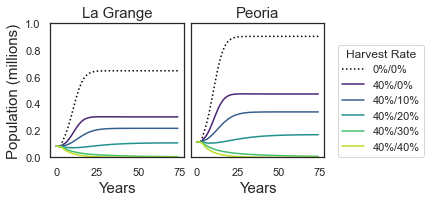

In [11]:
## Figure 3

labels = []
scenarios = []
models = []
for i in range(0, 50, 10):
    labels.append(f'40%/{i}%')
    scen, model = test_harvesting(0.005584, 0.4, i/100, title)
    scenarios.append(scen)
    models.append(model)
control_scen, model = test_harvesting(0.005584, 0, 0, '')

scen_to_graph = [scenarios[i] for i in [0, 2, 4]]
labels_to_graph = [labels[i] for i in [0, 2, 4]]
graph_results(scenarios, labels, 'Graphics', 'Effects of differing harvest regimes',
             control_scen, '0%/0%', 'Harvest Rate')

In [12]:
type(scenarios[0])

pandas.core.frame.DataFrame

# Test Size-Dependent Harvesting Impacts

In [13]:
def test_size_harvesting(g, h1_max, h1_cutoff, h2_max, h2_cutoff, title):
    # Set up pool a
    mask1 = node_data['Pool'] == 'a'
    node_data.loc[mask1, 'harvest_max'] = h1_max
    node_data.loc[mask1, 'harvest_inflection'] = h1_cutoff
    node_data.loc[mask1, 'harvest_slope'] = 1_000_000
    
    # Set up pool b
    mask2 = node_data['Pool'] == 'b'
    node_data.loc[mask2, 'harvest_max'] = h2_max
    node_data.loc[mask2, 'harvest_inflection'] = h2_cutoff
    node_data.loc[mask2, 'harvest_slope'] = 1_000_000
    
    results, model = test_model(g, title)
    
    # Clean up
    node_data.loc[mask1, 'harvest_max'] = 0
    node_data.loc[mask1, 'harvest_inflection'] = 0
    node_data.loc[mask1, 'harvest_slope'] = 0
    node_data.loc[mask2, 'harvest_max'] = 0
    node_data.loc[mask2, 'harvest_inflection'] = 0
    node_data.loc[mask2, 'harvest_slope'] = 0
    return results, model

C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\network.py:171: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  transition_data_use['prob'] = transition_data_use.iloc[
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\node.py:104: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  self.vonB_data['pars'] = self.vonB_data[vonB_columns].mean(1)
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\node.py:104: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this wil

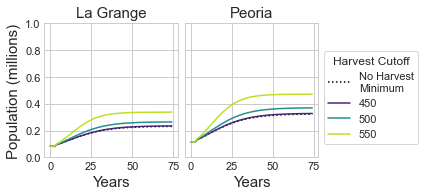

In [14]:
# Figure 5

labels = []
scenarios = []
models = []
for cutoff in range(450, 560, 50):
    labels.append(f'{cutoff}')
    scen, model = test_size_harvesting(0.005584, 0.20, cutoff, 0.20, cutoff, title)
    scenarios.append(scen)
    models.append(model)
control_scen, model = test_size_harvesting(0.005584, 0.20, 0, 0.20, 0, '')

graph_results(scenarios, labels, 'Graphics', 'Effects of differing harvest cutoffs',
             control_scen, 'No Harvest\nMinimum', 'Harvest Cutoff')

# Test Migration Reduction Impacts

In [15]:
def test_migration(mab, mba, title):
    orig_mab = transition_data.loc[0, 'ab']
    orig_mba = transition_data.loc[0, 'ba']
    transition_data.loc[0, 'ab'] = mab
    transition_data.loc[0, 'ba'] = mba
    results, model = test_model(0.005584, title)
    transition_data.loc[0, 'ab'] = orig_mab
    transition_data.loc[0, 'ba'] = orig_mba
    return results, model

C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\network.py:171: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  transition_data_use['prob'] = transition_data_use.iloc[
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\node.py:104: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  self.vonB_data['pars'] = self.vonB_data[vonB_columns].mean(1)
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\node.py:104: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this wil

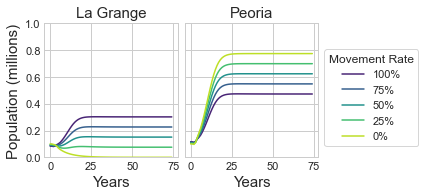

In [16]:
# Figure 4

mask = node_data['Pool'] == 'a'
node_data.loc[mask, 'harvest_max'] = 0.8
    
mask = node_data['Pool'] == 'b'
node_data.loc[mask, 'harvest_max'] = 0

ab = 0.2777
ba = 0.1948
labels = []
scenarios = []
models = []
for i in range(0, 125, 25):
    labels.append(f'{100-i}%')
    scen, model = test_migration(ab*(100-i)/100, ba*(100-i)/100, title)
    scenarios.append(scen)
    models.append(model)

scen_to_graph = [scenarios[i] for i in [0, 2, 4]]
labels_to_graph = [labels[i] for i in [0, 2, 4]]
graph_results(scenarios, labels, 'Graphics', 'Effects of reducing movement', 
              label_title='Movement Rate')

C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\summarize_outputs.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_out = data_out.append(pop_year_mo)
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\summarize_outputs.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_out = data_out.append(pop_year_mo)
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\summarize_outputs.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_out = data_out.append(pop_year_mo)
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\summarize_outputs.py:39: FutureWarning: 

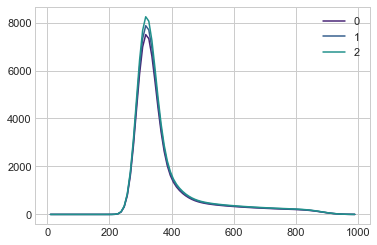

C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\summarize_outputs.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_out = data_out.append(pop_year_mo)
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\summarize_outputs.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_out = data_out.append(pop_year_mo)
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\summarize_outputs.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_out = data_out.append(pop_year_mo)
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\summarize_outputs.py:39: FutureWarning: 

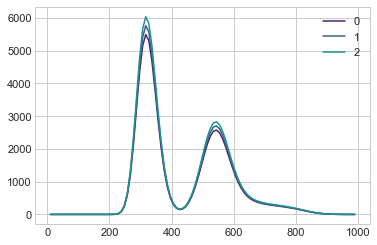

C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\summarize_outputs.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_out = data_out.append(pop_year_mo)
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\summarize_outputs.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_out = data_out.append(pop_year_mo)
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\summarize_outputs.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_out = data_out.append(pop_year_mo)
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\summarize_outputs.py:39: FutureWarning: 

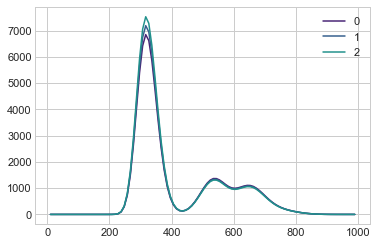

C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\summarize_outputs.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_out = data_out.append(pop_year_mo)
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\summarize_outputs.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_out = data_out.append(pop_year_mo)
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\summarize_outputs.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_out = data_out.append(pop_year_mo)
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\summarize_outputs.py:39: FutureWarning: 

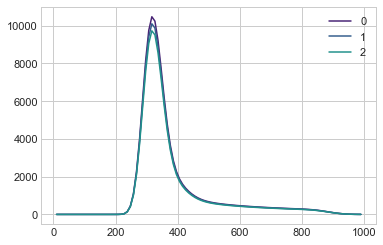

C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\summarize_outputs.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_out = data_out.append(pop_year_mo)
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\summarize_outputs.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_out = data_out.append(pop_year_mo)
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\summarize_outputs.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_out = data_out.append(pop_year_mo)
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\summarize_outputs.py:39: FutureWarning: 

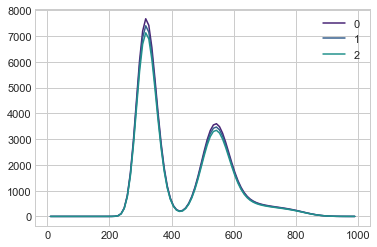

C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\summarize_outputs.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_out = data_out.append(pop_year_mo)
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\summarize_outputs.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_out = data_out.append(pop_year_mo)
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\summarize_outputs.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_out = data_out.append(pop_year_mo)
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\summarize_outputs.py:39: FutureWarning: 

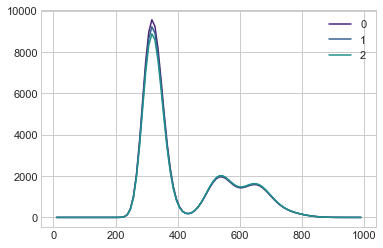

In [17]:
def extract_length_dists(model):
    out_all = so.extract_all_populations(model)
    out_all = out_all[out_all["Year"] < out_all["Year"].max()]
    
    out_by_node = out_all.groupby(['Year','Month','Node', 'Length'])[['Population']].sum().reset_index()
    out_by_node["Months"] = out_by_node["Month"] + out_by_node["Year"]
    out_by_node = out_by_node[out_by_node["Month"] == 0]
    out_by_node['Years'] = out_by_node['Months']
    return out_by_node[['Years', 'Node', 'Length', 'Population']]
model_to_graph = [models[0], models[2], models[4]]
for i in range(len(model_to_graph)):
    length_dists = extract_length_dists(models[i])
    mask = (length_dists['Years'] == 1) & (length_dists['Node'] == 'a')
    year0 = length_dists[mask]
    plt.plot(year0['Length'], year0['Population'], label=i)
plt.legend()
plt.show()

for i in range(len(model_to_graph)):
    length_dists = extract_length_dists(models[i])
    mask = (length_dists['Years'] == 2) & (length_dists['Node'] == 'a')
    year0 = length_dists[mask]
    plt.plot(year0['Length'], year0['Population'], label=i)
plt.legend()
plt.show()

for i in range(len(model_to_graph)):
    length_dists = extract_length_dists(models[i])
    mask = (length_dists['Years'] == 3) & (length_dists['Node'] == 'a')
    year0 = length_dists[mask]
    plt.plot(year0['Length'], year0['Population'], label=i)
plt.legend()
plt.show()

for i in range(len(model_to_graph)):
    length_dists = extract_length_dists(models[i])
    mask = (length_dists['Years'] == 1) & (length_dists['Node'] == 'b')
    year0 = length_dists[mask]
    plt.plot(year0['Length'], year0['Population'], label=i)
plt.legend()
plt.show()

for i in range(len(model_to_graph)):
    length_dists = extract_length_dists(models[i])
    mask = (length_dists['Years'] == 2) & (length_dists['Node'] == 'b')
    year0 = length_dists[mask]
    plt.plot(year0['Length'], year0['Population'], label=i)
plt.legend()
plt.show()

for i in range(len(model_to_graph)):
    length_dists = extract_length_dists(models[i])
    mask = (length_dists['Years'] == 3) & (length_dists['Node'] == 'b')
    year0 = length_dists[mask]
    plt.plot(year0['Length'], year0['Population'], label=i)
plt.legend()
plt.show()

C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\summarize_outputs.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_out = data_out.append(pop_year_mo)
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\summarize_outputs.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_out = data_out.append(pop_year_mo)
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\summarize_outputs.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_out = data_out.append(pop_year_mo)
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\summarize_outputs.py:39: FutureWarning: 

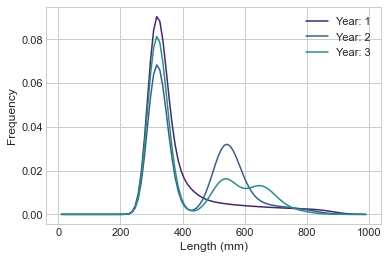

C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\summarize_outputs.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_out = data_out.append(pop_year_mo)
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\summarize_outputs.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_out = data_out.append(pop_year_mo)
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\summarize_outputs.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_out = data_out.append(pop_year_mo)
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\summarize_outputs.py:39: FutureWarning: 

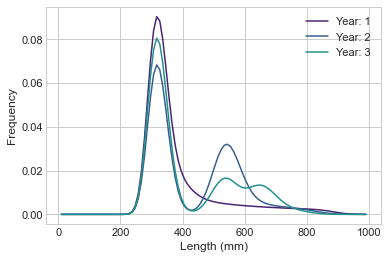

In [18]:
for year in range(1,4):
    length_dists = extract_length_dists(models[0])
    mask = (length_dists['Years'] == year) & (length_dists['Node'] == 'a')
    year0 = length_dists[mask]
    plt.plot(year0['Length'], year0['Population']/year0['Population'].sum(), label=f'Year: {year}')
plt.xlabel('Length (mm)')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('Node a Dists.png')
plt.show()

for year in range(1,4):
    length_dists = extract_length_dists(models[0])
    mask = (length_dists['Years'] == year) & (length_dists['Node'] == 'b')
    year0 = length_dists[mask]
    plt.plot(year0['Length'], year0['Population']/year0['Population'].sum(), label=f'Year: {year}')
plt.xlabel('Length (mm)')
plt.ylabel('Frequency')
plt.savefig('Node b Dists.png')
plt.legend()
plt.show()

In [19]:
labels = ['La Grange', 'Both']
scenarios = []
scenarios.append(test_harvesting(10**-7, 0.4, 0, 'Need to Remove This Part'))
scenarios.append(test_harvesting(10**-7, 0.4, 0.4, 'Need to Remove This Part'))

graph_results(scenarios, labels, 'Harvesting in one or two pools')

C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\network.py:171: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  transition_data_use['prob'] = transition_data_use.iloc[
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\node.py:104: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  self.vonB_data['pars'] = self.vonB_data[vonB_columns].mean(1)
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\node.py:104: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this wil

TypeError: graph_results() missing 1 required positional argument: 'title'

In [ ]:
graph_results(scenarios, labels, 'Harvesting in one or two pools')

In [ ]:
extract_population(models[0])